In [1]:
#import packages
import copy
import datetime
import pandas as pd
import numpy as np
import scipy

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style( 'whitegrid' )

# Parameters

In [3]:
pm = {
    # Model parameters
    'h': 7, # Number of days into the future we want to predict article count for.
    'h_range': [ 1, 2, 4, 7, 14, 30 ], # Spread of days that we will include data from.
    
    'seed': 15231,
    
    # Filters
    'required_rank': 3,
    'required_sentiment': -1.,
    
    # For test purposes
    'test_size': 0.2,
}

In [4]:
# The features used for the models.
# From my brief exploration I found that this
# edged out other combinations,
# including data that uses the article count in the prior set of days.
# Honestly I don't guarantee this is the best combinaiton.
features = [
    # 'DiffOverDay',
    'AdjClose',
    'logVolume',
    'DeltaAdjClose2',
    # 'SigmaAdjClose14',
    'DeltalogVolume2',
    'ArticleCountPrior{}'.format( pm['h'] ),
]
# features += [ 'DeltaAdjClose{}'.format( h ) for h in pm['h_range'] ]
# features += [ 'SigmaAdjClose{}'.format( h ) for h in pm['h_range'] ]
# features += [ 'DeltalogVolume{}'.format( h ) for h in pm['h_range'] ]
# features += [ 'ArticleCountPrior{}'.format( h ) for h in pm['h_range'] ]

In [5]:
rng = np.random.default_rng(pm['seed'])

# Load Data

In [6]:
# Market data
markets = pd.read_csv( '../data/train/markets.csv', )
markets['Date'] = pd.to_datetime( markets['Date'], utc=True )
markets.set_index( 'Date', inplace=True )

In [7]:
# Media
media = pd.read_csv( '../data/train/media.csv', parse_dates=[ 'pub_date', ], index_col='pub_date'  )
if 'Unnamed: 0' in media.columns:
    media.drop( 'Unnamed: 0', axis=1, inplace=True )

In [8]:
# Filter media
media = media.loc[media['relevance_rank']<=pm['required_rank']]
media = media.loc[media['subjectivity']>=pm['required_sentiment']]

In [9]:
# Combined
markets_and_media = markets.join( media, how='outer', )
# Denote origin
markets_and_media['market_or_media'] = 'market'
markets_and_media.loc[markets_and_media['Close'].isna(),'market_or_media'] = 'media'

# Calculate Derived Features

## Markets

In [10]:
markets['logVolume'] = np.log10( markets['Volume'] )

In [11]:
markets['DiffOverDay'] = markets['AdjClose'] - markets['Open']

In [12]:
markets['DaysFromStart'] = ( markets.index - markets.index[0] ).days

In [13]:
for h in pm['h_range']:
    markets_roll = markets.rolling( pd.Timedelta( h, 'days' ) )
    markets['DeltaAdjClose{}'.format( h )] = markets_roll['AdjClose'].apply( lambda window: window[-1] - window[0], )
    markets['SigmaAdjClose{}'.format( h )] = markets_roll['AdjClose'].std()
    markets['DeltalogVolume{}'.format( h )] = markets_roll['logVolume'].apply( lambda window: window[-1] - window[0], )

## Combined

In [14]:
# Count the number of articles published within h_pub days into the future, using the market's dates
for h in pm['h_range']:
    
    # Actual Value
    mam_reverse_roll = markets_and_media[::-1].rolling( pd.Timedelta( h, 'days' ) )
    article_count = mam_reverse_roll['abstract'].count()
    markets['ArticleCount{}'.format(h)] = article_count
    
    # Classification approach
    markets['News{}'.format(h)] = 0
    markets.loc[markets['ArticleCount{}'.format(h)]>=1,'News{}'.format(h)] = 1
    
    # Prior article count
    mam_reverse_roll = markets_and_media.rolling( pd.Timedelta( h, 'days' ) )
    article_count = mam_reverse_roll['abstract'].count()
    markets['ArticleCountPrior{}'.format(h)] = article_count

    # Expectation if random
    markets['ArticleCountRandom{}'.format(h)] = rng.poisson( article_count.mean(), size=len( markets ) ).astype( float )

## Handle NaNs

In [15]:
markets.fillna( markets[features].mean( axis=0 ), inplace=True )

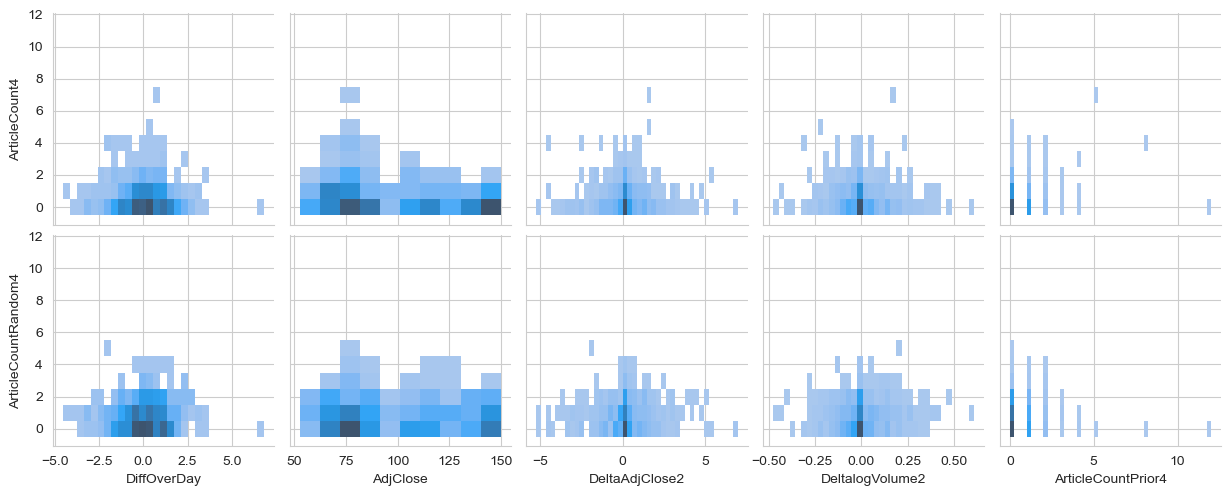

In [16]:
sns.pairplot(
    markets,
    x_vars = [ 'DiffOverDay', 'AdjClose', 'DeltaAdjClose2', 'DeltalogVolume2', 'ArticleCountPrior4' ],
    y_vars = [ 'ArticleCount4', 'ArticleCountRandom4' ],
    kind = 'hist',
    plot_kws = { 'bins': ( 'auto', np.arange( -0.5, markets['ArticleCount7'].max(), 1 ) ) },
)

# Prepare for Modeling

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve

In [19]:
h = pm['h']
y_key = 'ArticleCount{}'.format( h )
yc_key = 'News{}'.format( h )

## Separate into training and validation

In [20]:
start_date_test = markets.index[-1] - pm['test_size'] * ( markets.index[-1] - markets.index[0] )

In [21]:
markets_train = markets.loc[markets.index<start_date_test]
markets_test = markets.loc[markets.index>start_date_test]

In [22]:
X_train = markets_train[features].values
y_train = markets_train[y_key].values
yc_train = markets_train[yc_key]

In [23]:
X_test = markets_test[features].values
y_test = markets_test[y_key].values
yc_test = markets_test[yc_key]

## Normalize

In [24]:
# Scale the data
ss = StandardScaler()
ss.fit( X_train )
X_train = ss.transform( X_train )
X_test = ss.transform( X_test )

## Preview

<Axes: xlabel='Column', ylabel='Normalized'>

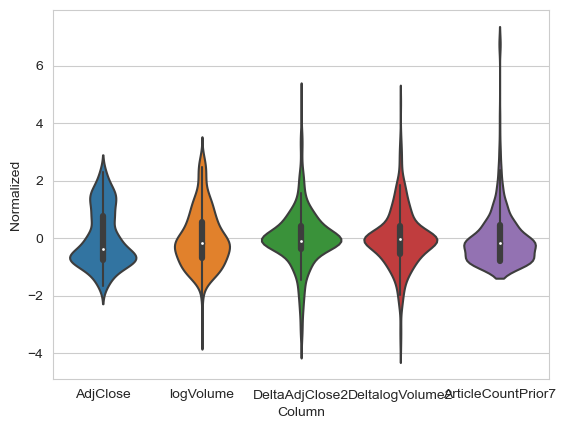

In [25]:
X_train_df = pd.DataFrame( X_train, columns=features, index=markets_train.index )
X_train_melted = X_train_df.melt( var_name='Column', value_name='Normalized' )
sns.violinplot( X_train_melted, x='Column', y='Normalized' )

In [67]:
Xy_train_df = pd.concat( [ X_train_df, markets_train[[y_key,yc_key]], ], axis=1 )

## Prep results storage

In [27]:
reg_results = {
    'model': [],
    'mse': [],
}
class_results = {
    'model': [],
    'acc_score': [],
    'auc': [],
}

# Base Model
Poisson distribution with mean from observations

## Regression

In [28]:
# Mean with noise
# y_pred_base = markets_test['ArticleCountRandom4'].values

# Mean without noise
y_pred_base = np.full( y_test.shape, markets_test['ArticleCount{}'.format(h)].mean() )

In [29]:
mse = mean_squared_error( y_test, y_pred_base, )
mse

0.31459054209919257

In [30]:
reg_results['model'].append( 'baseline' )
reg_results['mse'].append( mse )

## Classification

In [31]:
yc_pred_base = np.zeros( y_pred_base.shape, dtype=int )
yc_pred_base[y_pred_base>0.5] = 1

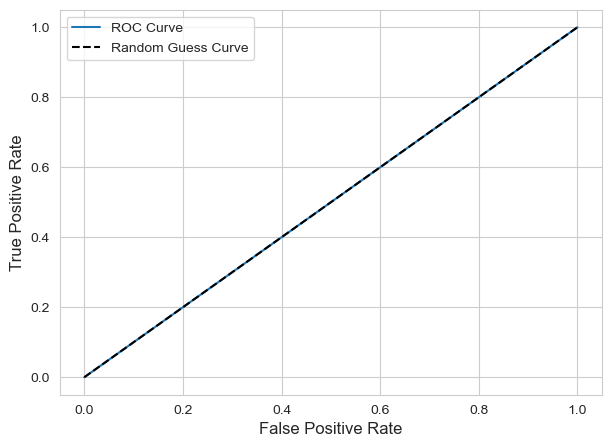

0.5

In [32]:
fprs, tprs, cutoffs = roc_curve( yc_test, y_pred_base )
                                
plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="ROC Curve")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

auc = np.trapz( tprs, fprs )
auc

In [33]:
acc_score = accuracy_score( yc_test, yc_pred_base )
acc_score

0.6568627450980392

In [34]:
class_results['model'].append( 'baseline' )
class_results['acc_score'].append( acc_score )
class_results['auc'].append( auc )

# Neural Networks

In [35]:
from sklearn.neural_network import MLPRegressor, MLPClassifier

## MLP (SKlearn)

### Regression

In [36]:
mlp = MLPRegressor()
mlp.fit( X_train, y_train )

/Users/zhafen/miniconda3/envs/erdos/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

In [37]:
y_pred = mlp.predict( X_test )

In [38]:
# Discretize
y_pred = np.round( y_pred, 0 ).astype( int )
y_pred[y_pred<0] = 0

In [39]:
mse = mean_squared_error( y_test, y_pred, )
mse

0.7156862745098039

In [40]:
reg_results['model'].append( 'MLP' )
reg_results['mse'].append( mse )

In [41]:
acc_score = accuracy_score( yc_test, y_pred )
acc_score

0.3431372549019608

### Classification

In [42]:
mlp = MLPClassifier()
mlp.fit( X_train, yc_train )

MLPClassifier()

In [43]:
y_pred = mlp.predict( X_test )

In [44]:
accuracy_score( yc_test, y_pred )

0.35294117647058826

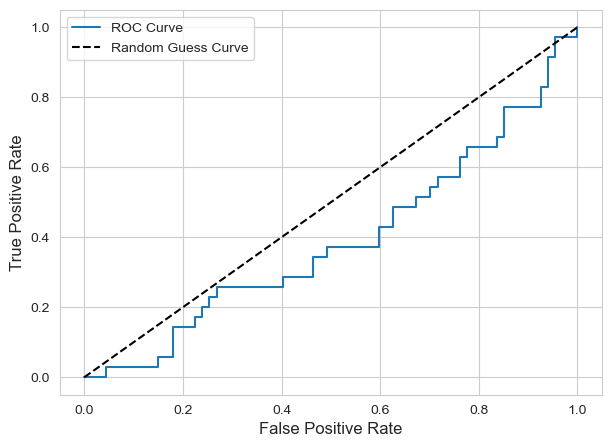

0.39019189765458423

In [45]:
fprs, tprs, cutoffs = roc_curve( yc_test, mlp.predict_proba( X_test )[:,1] )
                                
plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="ROC Curve")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

auc = np.trapz( tprs, fprs )
auc

In [46]:
class_results['model'].append( 'MLP' )
class_results['acc_score'].append( acc_score )
class_results['auc'].append( auc )

## Simple neural net (keras)
This is a duplicate from lecture

In [47]:
## import things
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils.np_utils import to_categorical

# for earlier versions of keras run this instead
# from keras.utils import to_categorical
# instead of running
# from keras.utils.np_utils import to_categorical
# or look up the documentation for your version

2023-06-02 12:14:18.105466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:

model = models.Sequential()

model.add(layers.Dense(32, activation='relu', input_shape=(len(features),) ) )

model.add(layers.Dense(32, activation='relu', ) )

model.add(layers.Dense(2, activation='softmax'))

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,314
Trainable params: 1,314
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='rmsprop', 
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [51]:
## I now fit the model, and store the training history
## I use 100 epochs and a batch_size of 512
n_epochs = 100
batch_size = 512



history = model.fit(X_train, to_categorical(yc_train),
                       epochs = n_epochs,
                       batch_size = batch_size,
                       validation_data = (X_test, to_categorical(yc_test)))

Epoch 1/100
1/1 [==============================] - 0s 477ms/step - loss: 0.6822 - accuracy: 0.6129 - val_loss: 0.8702 - val_accuracy: 0.3529
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 0.6709 - accuracy: 0.6402 - val_loss: 0.8619 - val_accuracy: 0.3627
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 0.6644 - accuracy: 0.6377 - val_loss: 0.8513 - val_accuracy: 0.3529
Epoch 4/100
1/1 [==============================] - 0s 22ms/step - loss: 0.6596 - accuracy: 0.6452 - val_loss: 0.8415 - val_accuracy: 0.3529
Epoch 5/100
1/1 [==============================] - 0s 22ms/step - loss: 0.6557 - accuracy: 0.6476 - val_loss: 0.8342 - val_accuracy: 0.3529
Epoch 6/100
1/1 [==============================] - 0s 22ms/step - loss: 0.6524 - accuracy: 0.6476 - val_loss: 0.8264 - val_accuracy: 0.3627
Epoch 7/100
1/1 [==============================] - 0s 21ms/step - loss: 0.6495 - accuracy: 0.6476 - val_loss: 0.8193 - val_accuracy: 0.3627
Epoch 8/100
1/1 [==

In [52]:
history_dict = history.history

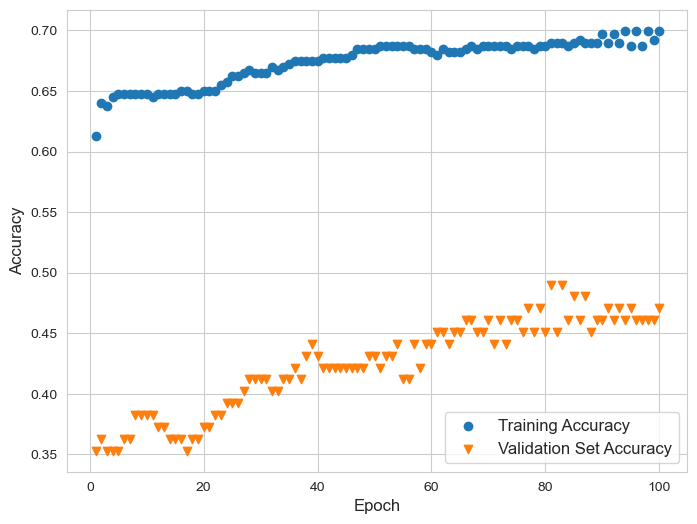

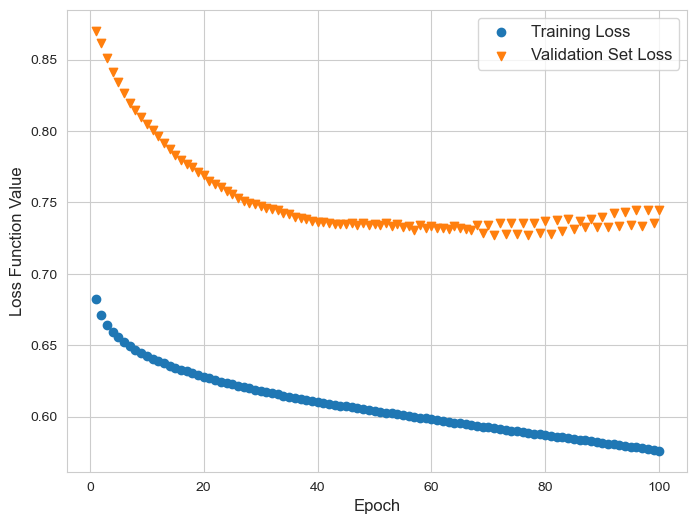

In [53]:
plt.figure(figsize = (8,6))

plt.scatter(range(1,n_epochs+1), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,n_epochs+1), history_dict['val_accuracy'], marker='v', label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()


plt.figure(figsize = (8,6))

plt.scatter(range(1,n_epochs+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,n_epochs+1), history_dict['val_loss'], marker='v', label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

In [54]:
y_train_proba = model.predict(X_train)

13/13 [==============================] - 0s 681us/step


In [55]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1 )

4/4 [==============================] - 0s 949us/step


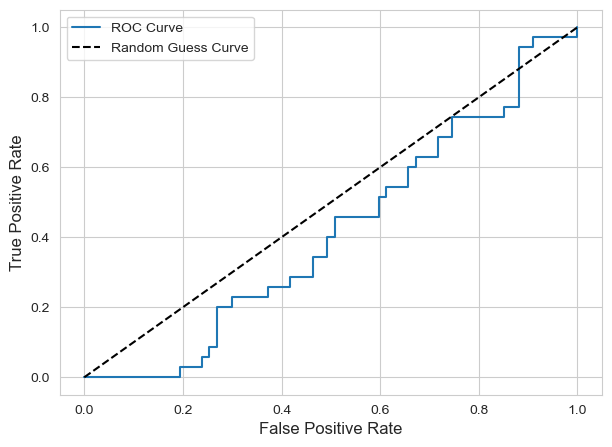

In [56]:
fprs, tprs, cutoffs = roc_curve( yc_test, y_pred_proba[:,1] )
                                
plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="ROC Curve")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

In [57]:
acc_score = accuracy_score( yc_test, y_pred )
acc_score

0.47058823529411764

In [58]:
class_results['model'].append( 'simple neural net' )
class_results['acc_score'].append( acc_score )
class_results['auc'].append( auc )

## Recurrent Neural Network

In [70]:
Xy_train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AdjClose,403.0,-1.410507e-16,1.001243,-1.679020,-0.747608,-0.364839,0.770148,2.295182
logVolume,403.0,-2.115760e-16,1.001243,-3.256805,-0.694179,-0.169602,0.572788,2.923507
DeltaAdjClose2,403.0,0.000000e+00,1.001243,-3.565346,-0.366520,-0.090186,0.427680,4.798474
DeltalogVolume2,403.0,-8.815667e-18,1.001243,-3.722429,-0.549086,-0.018493,0.421107,4.719184
ArticleCountPrior7,403.0,-5.289400e-17,1.001243,-0.789733,-0.789733,-0.160756,0.468221,6.757990
ArticleCount7,403.0,1.225806e+00,1.593247,0.000000,0.000000,1.000000,2.000000,12.000000
News7,403.0,6.426799e-01,0.479806,0.000000,0.000000,1.000000,1.000000,1.000000


# Display Results

(0.0, 0.7872549019607844)

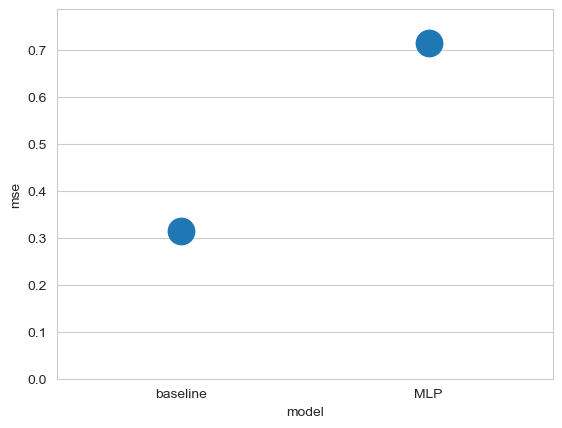

In [60]:
fig = plt.figure()
ax = plt.gca()

sns.stripplot(
    reg_results,
    x = 'model',
    y = 'mse',
    ax = ax,
    s = 20,
)

ax.set_ylim( 0, np.max( reg_results['mse'] ) * 1.1 )

(0.0, 1.0)

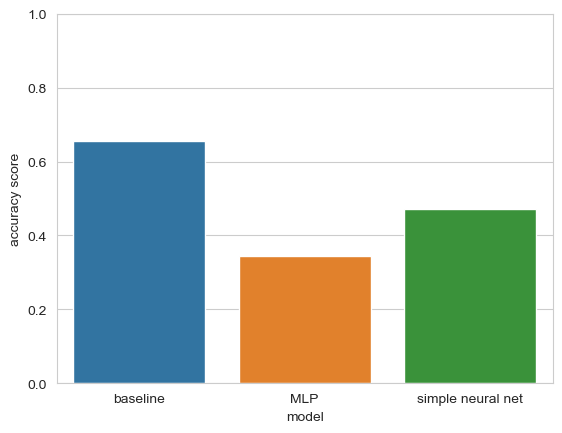

In [61]:
fig = plt.figure()
ax = plt.gca()

sns.barplot(
    class_results,
    x = 'model',
    y = 'acc_score',
    ax = ax,
)

ax.set_xlabel( 'model' )
ax.set_ylabel( 'accuracy score' )

ax.set_ylim( 0, 1 )

(0.0, 1.0)

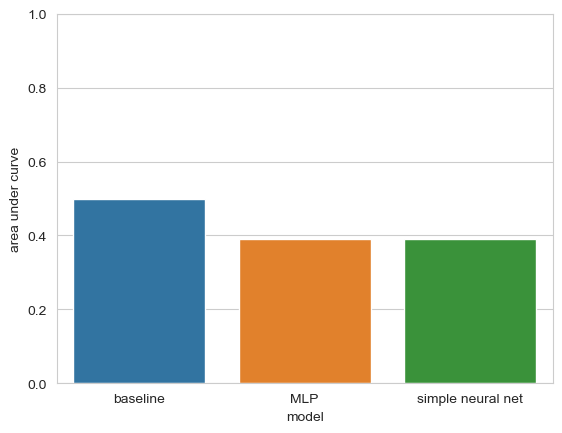

In [62]:
fig = plt.figure()
ax = plt.gca()

sns.barplot(
    class_results,
    x = 'model',
    y = 'auc',
    ax = ax,
)

ax.set_xlabel( 'model' )
ax.set_ylabel( 'area under curve' )

ax.set_ylim( 0, 1 )